<a href="https://github.com/lexx010?tab=repositories">
    <img src="img/github_sm.png">
</a>

In [3]:
import pandas as pd
import string
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Jeopardy Questions

**Jeopardy!** is a long-running U.S. quiz show where contestants answer questions to win money. This project analyzes a dataset of over 200,000 questions to uncover patterns that could help contestants gain an edge.

You can access the full dataset [here](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file).

## Dataset Overview
Each row represents a single question from an episode:

- **Show Number** – Episode ID  
- **Air Date** – Date aired  
- **Round** – Jeopardy, Double Jeopardy, Final Jeopardy, or Tiebreaker  
- **Category** – Question topic  
- **Value** – Dollar amount for the correct answer  
- **Question** – Clue text  
- **Answer** – Correct response  

## Goal
Analyze **question overlap, category trends, and round-specific patterns** to identify insights that can help contestants prepare more effectively.



In [126]:
# load dataset
df = pd.read_csv('JEOPARDY_CSV.csv')

In [3]:
df.head(5)

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [7]:
df.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [9]:
df.columns = df.columns.str.strip()

In [11]:
df.columns

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

##  Normalizing Text
Before analyzing the Jeopardy questions, it's important to normalize the text in the **Question** and **Answer** columns. This involves creating a function to clean and standardize the text, then applying it to both columns to prepare the data for analysis.


In [26]:
df.dtypes

Show Number        int64
Air Date          object
Round             object
Category          object
Value             object
Question          object
Answer            object
clean_question    object
dtype: object

In [28]:
def norm_text(text):
    if not isinstance(text, str):  # to handle NaN or float AttributeError.
        return ""
    text = text.lower()
    text = ''.join(char for char in text if char not in string.punctuation)
    return text

In [30]:
df['clean_question'] = df['Question'].apply(norm_text)
df['clean_answer'] = df['Answer'].apply(norm_text)

## Normalizing Columns
After normalizing the text columns, other columns also need standardization:

- **Value**: Convert from text to numeric by removing the dollar sign and handling missing or invalid entries. This allows easier calculations and comparisons.
- **Air Date**: Convert from string to `datetime` format to facilitate date-based analysis.


In [31]:
def normalize_value(value):
    try:
        value_str = str(value)
        value_str = ''.join(char for char in value_str if char not in string.punctuation)
        # Convert to integer
        return int(value_str)
    except:
        return 0

# Apply the function to normalize the Value column
df['clean_value'] = df['Value'].apply(normalize_value)

# convert to datetimme format
df['Air Date'] = pd.to_datetime(df['Air Date'])

# Check the result
print(df[['clean_value', 'Air Date']].head())

    

   clean_value   Air Date
0          200 2004-12-31
1          200 2004-12-31
2          200 2004-12-31
3          200 2004-12-31
4          200 2004-12-31


In [34]:
df.head(5)

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus,200
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisle i...,jim thorpe,200
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona,200
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,in 1963 live on the art linkletter show this c...,mcdonalds,200
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,signer of the dec of indep framer of the const...,john adams,200


##  Answers in Questions
To decide whether to study past questions, general knowledge, or not study at all, it helps to examine two things:

1. **Answer overlap**: How often words in the answer also appear in the question.
2. **Question repetition**: How often complex words (longer than 6 characters) reoccur across questions.

We'll first focus on analyzing answer overlap. To make this analysis more meaningful, we'll create a list of **custom stopwords** to filter out common words that provide little information:

```python
custom_stopwords = {
    "the", "a", "an", "and", "or", "but", "than", "then", 
    "with", "without", "from", "into", "onto", "for", "of", 
    "at", "to", "in", "on", "by", "is", "are", "was", "were"
}


In [40]:
custom_stopwords = {
    "the", "a", "an", "and", "or", "but", "than", "then", 
    "with", "without", "from", "into", "onto", "for", "of", 
    "at", "to", "in", "on", "by", "is", "are", "was", "were"
}

def question_answer_split_ratio(row):
    split_answer = row['clean_answer'].split(" ")
    split_question = row['clean_question'].split(" ")
    
    match_count = 0
    # Remove stopwords present in the answer
    filtered_answer = []
    for w in split_answer:
        if w not in custom_stopwords:
            filtered_answer.append(w)
        split_answer = filtered_answer
   
    # Avoid division by zero    
    if len(split_answer) == 0:
        return 0
    
    for i in split_answer:
        if i in split_question:
            match_count += 1
    
    # Ratio of matches
    return match_count / len(split_answer)

# Count how many times terms in clean_answer occur in clean_question.

df['answer_in_question'] = df.apply(question_answer_split_ratio, axis=1)

mean_answer_ratio  = df['answer_in_question'].mean()
print(f' The mean of the answer_in_question: ', {mean_answer_ratio})


 The mean of the answer_in_question:  {0.04067668138854697}


**Observation:**  

Only about **4%** of the informative words in the answer appear in the corresponding question after filtering out common stopwords such as *the, and, of, in,* etc.  

This suggests that most answers on Jeopardy are not directly repeated in the question, highlighting the importance of general knowledge and context over simple word matching.


## Recycled Questions

To investigate how often new questions repeat older ones, we can:

1. Sort the `jeopardy` dataset by ascending `Air Date`.
2. Initialize an empty set called `terms_used`.
3. Iterate through each question:
   - Split `clean_question` into words.
   - Remove words shorter than 6 characters.
   - Check if each remaining word is already in `terms_used`. If yes, increment a counter.
   - Add each word to `terms_used`.

Focusing on words with 6+ characters filters out common words like *the* and *than*, which are not informative, allowing us to track meaningful repetition in questions.


In [61]:
question_overlap = []
terms_used = set()

for id, row in df.iterrows():
    split_question = row['clean_question'].split(" ")
    
  # Keep only words with length >= 6    
    split_question = [word for word in split_question if len(word) >= 6]
    
    match_count = 0
    
    for word in split_question:
        if word in terms_used:
            match_count += 1
            
    for word in split_question:
        terms_used.add(word)
    
    if len(split_question) > 0:
        overlap = match_count / len(split_question)
    else:
        overlap = 0
        
    question_overlap.append(overlap)
    
 # Assign question_overlap to the question_overlap column of jeopardy.

df['question_overlap'] = question_overlap

mean_overlap = df['question_overlap'].mean()
print(f'The mean of the question_overlap is:', {mean_overlap})
    

The mean of the question_overlap is: {0.8729646759745024}


**Observation:**  

The mean question overlap is very high (≈87%), which indicates that, on average, more than 87% of the meaningful words (6+ characters) in each question have already appeared in previous Jeopardy questions.  

In other words, nearly 9 out of 10 significant words in a question are repeated terms from earlier questions in the dataset.


## Low Value vs High Value Questions

To focus on questions that could earn more money, we can analyze which words are more common in high-value questions using a chi-squared test.

**Steps:**

1. **Categorize Questions**  
   - **Low value**: Value < 800  
   - **High value**: Value > 800  

2. **Analyze Term Frequency**  
   For each word in `terms_used`:
   - Count how many low-value questions the word appears in.
   - Count how many high-value questions the word appears in.
   - Compute expected counts based on overall occurrence.

3. **Compute Chi-Squared Statistic**  
   - Compare observed vs. expected counts for high- and low-value questions.
   - Words with the highest chi-squared values indicate the biggest differences in usage between high- and low-value questions.


To analyze which words are more common in high-value questions, we first classify each question as either **Low Value** (questions worth less than \$800) or **High Value** (questions worth more than \$800).

We then count, for a sample of words, how often each word appears in Low Value and High Value questions. This allows us to compare observed versus expected frequencies and identify terms that are disproportionately associated with higher-value questions using a chi-squared test.


In [63]:
df.columns

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer', 'clean_question', 'clean_answer', 'clean_value',
       'answer_in_question', 'question_overlap', 'high_value'],
      dtype='object')

In [67]:
def determine_value(row):
    if row['clean_value'] > 800:
        return 1
    else:
        return 0

df['high_value'] = df.apply(determine_value, axis=1)


In [68]:
# df.sample(10)

In [71]:
def count_word(word):
    low_count = 0
    high_count = 0
    
    for idx, row in df.iterrows():
        words = row['clean_question'].split(" ")
        if word in words:
            if row['high_value'] == 1:
                high_count += 1
            else:
                low_count += 1
                
    return high_count, low_count
    

In [73]:
# Randomly pick ten elements of terms_used and append them to a list called comparison_terms.
comparison_terms = random.sample(list(terms_used),10)
print(comparison_terms)

['violation', 'salamanders', 'magazine', 'sowith', 'coincides', 'erdarelli', 'tiptoeing', 'nyerere', 'grebes', 'brusteins']


In [75]:
# Create an empty list called observed_expected
observed_expected = []

for term in comparison_terms:
    observed_expected.append(count_word(term))
    
print(observed_expected)

[(8, 10), (0, 5), (135, 456), (3, 0), (3, 5), (1, 0), (1, 0), (1, 1), (0, 1), (1, 0)]


## Applying the Chi-squared Test

Once we have the observed counts for a set of terms, we can:

1. Compute the expected counts for High Value and Low Value questions based on their overall proportions in the dataset.  
2. Apply the chi-squared test to compare observed versus expected counts.  

This step allows us to quantify whether the occurrence of specific terms is significantly associated with high-value questions.


In [80]:
# Applying the Chi-squared Test
from scipy.stats import chisquare

# find high and low value rows

high_value_count = (df['high_value'] == 1).sum()
low_value_count = (df['high_value'] == 0).sum()


In [85]:
chi_squared = []

for term, obs in zip(comparison_terms, observed_expected):
    total = sum(obs)
    if total == 0:   # avoid division by zero
        continue
    
    total_prop = total / len(df)   
    expected_high = total_prop * high_value_count
    expected_low = total_prop * low_value_count

    observed = np.array([obs[0], obs[1]])
    expected = np.array([expected_high, expected_low])

    chi2, pval = chisquare(observed, expected)
    chi_squared.append((term, chi2, pval))

# Put into DataFrame for easier analysis
chi_df = pd.DataFrame(chi_squared, columns=["term", "chi2", "pval"])

# Sort by significance
chi_df = chi_df.sort_values("pval")
chi_df.head(10)


,term,chi2,pval
2,magazine,8.717117,0.003152
3,sowith,7.595389,0.005852
5,erdarelli,2.531796,0.111573
6,tiptoeing,2.531796,0.111573
9,brusteins,2.531796,0.111573
0,violation,2.307368,0.128762
1,salamanders,1.974882,0.159931
7,nyerere,0.463386,0.496046
8,grebes,0.394976,0.529695
4,coincides,0.332572,0.564148


### Observations

- Most p-values are above the typical significance threshold (0.05).  
- **Exceptions:**
  - *magazine* (p = 0.0032)  
  - *sowith* (p = 0.0059)  

These two terms are significantly associated with differences in frequency between high-value and low-value questions.  

---

### Implications

- For the majority of sampled terms, there is **no strong evidence** that they are predictive of high-value questions.  
- A couple of terms (*magazine*, *sowith*) do show significance, but this may be due to chance given the small sample.  
- To draw stronger conclusions, we should:  
  - Expand the analysis to a **larger set of words**.  
  - Focus on **frequently occurring terms** rather than rare ones.  


##  Category Patterns 

The `Category` column represents the subject of each Jeopardy question.  

Key analyses performed:

1. **Top Categories:** Identified the top 20 most frequent categories overall.  
2. **Count per Round:** Calculated how often each category appears in each round.  
3. **Category Frequency & Probability by Round:** Computed the probability of each category appearing in each round, highlighting which topics dominate certain rounds.

These analyses help uncover patterns in question topics and round-specific trends.


In [88]:
category_counts = df['Category'].value_counts()

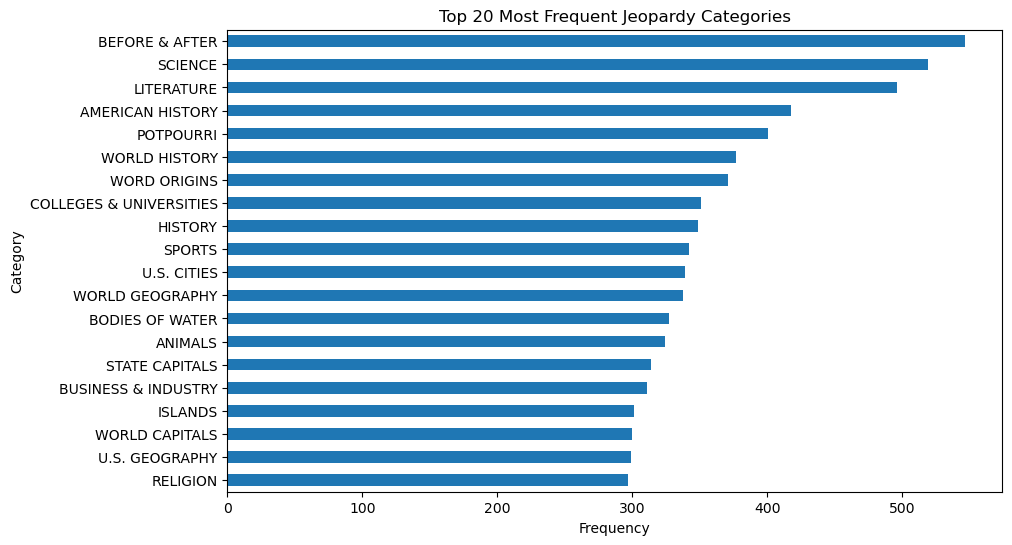

In [90]:
category_counts.head(20).plot(kind='barh', figsize=(10,6))
plt.title("Top 20 Most Frequent Jeopardy Categories")
plt.xlabel("Frequency")
plt.ylabel("Category")
plt.gca().invert_yaxis() 
plt.show()
plt.show()

In [99]:
# Count categories per round
category_round = df.groupby(["Round", "Category"]).size().reset_index(name="count")

# Total counts per round
round_totals = category_round.groupby("Round")["count"].sum().reset_index(name="total_count")

# Merge totals back
category_round = category_round.merge(round_totals, on="Round")

# Compute probability
category_round["probability"] = category_round["count"] / category_round["total_count"]

# Keep only relevant columns
category_round = category_round[["Round", "Category", "count", "probability"]]

print(category_round.head(20))

               Round              Category  count  probability
0   Double Jeopardy!               "-ARES"      5     0.000047
1   Double Jeopardy!         "...OD" WORDS      5     0.000047
2   Double Jeopardy!         "1", "2", "3"      5     0.000047
3   Double Jeopardy!        "20" QUESTIONS      5     0.000047
4   Double Jeopardy!               "A" + 4      5     0.000047
5   Double Jeopardy!        "A" IN COLLEGE      5     0.000047
6   Double Jeopardy!      "A" IN GEOGRAPHY     15     0.000142
7   Double Jeopardy!     "A" IN LITERATURE      5     0.000047
8   Double Jeopardy!           "A" IN MATH      5     0.000047
9   Double Jeopardy!        "A" IN SCIENCE     15     0.000142
10  Double Jeopardy!  "A" IN SEX EDUCATION      5     0.000047
11  Double Jeopardy!    "A" IN SHAKESPEARE      5     0.000047
12  Double Jeopardy!                "A" OK      5     0.000047
13  Double Jeopardy!              "A" PLUS     24     0.000227
14  Double Jeopardy!  "A" SCIENCE CATEGORY      4     0

### Category Frequency and Probability by Round

- We computed the frequency of each category within each round and normalized by the total number of questions in that round.  
- The probabilities are quite small for individual categories (often < 0.01), showing that Jeopardy! covers a **very wide range of categories**.  
- Some categories (e.g., `"A" PLUS`, `"A" IN SCIENCE`, `"A" IN GEOGRAPHY`) appear more often than others, suggesting **recurring themes**.  
- Overall, the distribution highlights the **diversity of categories** across rounds, with no single category dominating.


## Category Patterns Across Rounds

Analyzing the top 10 categories in each round highlights distinct patterns in topic focus and diversity. Some rounds tend to feature recurring themes, while others show a wider variety of categories. This section examines these trends to understand how Jeopardy content varies across rounds.


In [115]:
# Pivot the category-round probabilities
category_pivot = category_round.pivot(index="Category", columns="Round", values="probability")

# Optional: fill missing values with 0 (if a category doesn't appear in a round)
category_pivot = category_pivot.fillna(0)


In [117]:
# We'll use the pivot table with probabilities: category_pivot_only

top_categories_per_round = {}

for round_name in category_pivot.columns:
    # Sort categories by probability for this round, descending
    top_10 = category_pivot[round_name].sort_values(ascending=False).head(10)
    top_categories_per_round[round_name] = top_10

# Print top 10 categories per round
for round_name, top_10 in top_categories_per_round.items():
    print(f"\nTop 10 categories in {round_name}:\n")
    print(top_10)



Top 10 categories in Double Jeopardy!:

Category
BEFORE & AFTER             0.004249
LITERATURE                 0.003597
SCIENCE                    0.002795
WORLD GEOGRAPHY            0.002398
OPERA                      0.002360
WORLD HISTORY              0.002238
BALLET                     0.002172
COLLEGES & UNIVERSITIES    0.002077
ISLANDS                    0.002030
ART                        0.002030
Name: Double Jeopardy!, dtype: float64

Top 10 categories in Final Jeopardy!:

Category
U.S. PRESIDENTS        0.013770
WORD ORIGINS           0.009364
STATE CAPITALS         0.008538
AUTHORS                0.007436
WORLD LEADERS          0.007161
FAMOUS NAMES           0.006610
FAMOUS AMERICANS       0.006610
HISTORIC NAMES         0.006610
BUSINESS & INDUSTRY    0.006334
U.S. CITIES            0.005233
Name: Final Jeopardy!, dtype: float64

Top 10 categories in Jeopardy!:

Category
POTPOURRI              0.002375
STUPID ANSWERS         0.002375
SPORTS                 0.002356
ANIMA

### Conclusion: Category Patterns Across Rounds

The analysis of the top 10 categories per round reveals clear differences in focus and diversity:

- **Double Jeopardy!**  
  The most common categories include *Before & After*, *Literature*, *Science*, and *World Geography*.  
  This round tends to emphasize a mix of wordplay (*Before & After*), academic fields (*Literature*, *Science*), and cultural knowledge (*Opera*, *Ballet*, *Art*).  

- **Final Jeopardy!**  
  The round is dominated by historically and politically oriented categories, especially *U.S. Presidents*, *Word Origins*, and *State Capitals*.  
  This suggests that the final round often tests deeper knowledge of U.S. history, politics, and language.  

- **Jeopardy! (regular round)**  
  The most frequent categories are broader and often lighter, such as *Potpourri*, *Stupid Answers*, *Sports*, and *Television*.  
  Academic categories like *Science* and *American History* also appear, but at lower probabilities compared to Double Jeopardy!.  

- **Tiebreaker**  
  With very few data points, categories like *Child’s Play*, *The American Revolution*, and *Literary Characters* appear.  
  However, the small sample size makes this round less reliable for broad insights.  

### Key Takeaways
- **Early rounds (Jeopardy!)** are more diverse and playful, covering a wide range of general knowledge.  
- **Double Jeopardy!** focuses more heavily on academic and cultural subjects, raising the difficulty level.  
- **Final Jeopardy!** leans toward high-stakes, serious categories, especially U.S. history and politics.  
- **Category diversity** appears highest in Jeopardy! (broad range) and lowest in Final Jeopardy! (predictable, concentrated on history/politics).  
